In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d  
import cv2 as cv

import os
import sys
from copy import deepcopy

# Add src to path
sys.path.append("src")
from BWImage import BWImage
from sff import get_sff


## Jupyter notebooks settings.

# Reload modules before executing each cell.
%load_ext autoreload
%autoreload 2 

# Print all print statements.
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all" 

# Set white as color for pixels with no value.
BWImage.blank_value = 0

# Introduction

In this lab  we obtain the depth information from the focus measure.

## Theory
We are given an image stack and we do the following to get the shape of the input image stack. 

1. For each image in the image stack get modified laplacian, defined as:

$$ML(x, y) = |f_{xx}(x, y)| + |f_{yy}(x, y)|$$

2. Obtain sum modified laplacian, defined as:

$$SML(x, y) = \sum_{i = x-q}^{x+q}\sum_{j = y-q}^{j = y+q}ML(i, j)$$

3. At each pixel along the depth of the image stack we look for the maximum intensity $F_m$ and find a more appropriate interpolated depth by fitting a Gaussian curve over $F_{m-1}, F_m, F_{m+1}$.

## Implementation.
**Input**: `data/input`

**Output**: `data/output`

**Source code**: `src`

* `BWImage.py`: Same from my previous labs. Implements a class with methods for basic image I/O.

* `sff.py`: Implements the algorithm to get shape from focus as described in class. It contains the following functions:
    - `get_ml`: Gives modified laplacian for the input image.
    - `get_sml`: Give sum modified laplacian for the input image and q (window size).
    - `get_depth`: Given $F_{m-1}$, $F_m$ and $F_{m+1}$ returns the interpolated depth ($\bar{d}$) at with the focus measure is highest. 
    - `get_sff`: Takes as input an image stack and returns a 2D numpy array with the depth values ($\bar{d}$) at each pixel.



# Result

## Import data and visualize.

In [2]:
# Read input.
import scipy.io as sio
stack_mat = sio.loadmat('data/input/stack.mat')

# Print meta info.  
print("Header: ", stack_mat['__header__'])
print("Version: ", stack_mat['__version__'])
print("Number of frames", stack_mat['numframes'])
print("Dimension of each frame: ", stack_mat['frame001'].shape)

# Preprocess data.
img_stack = []
for i in range(stack_mat['numframes'][0][0]):
    if i < 9:
        img_stack.append(stack_mat['frame00' + str(i+1)])
    elif i < 99:
        img_stack.append(stack_mat['frame0' + str(i+1)])
    else:
        img_stack.append(stack_mat['frame' + str(i+1)])
img_stack = np.array(img_stack)

Header:  b'MATLAB 5.0 MAT-file, Platform: PCWIN, Created on: Fri Feb 05 14:40:11 2010'
Version:  1.0
Number of frames [[100]]
Dimension of each frame:  (115, 115)


## Get shape.

In [3]:
# Get the depth at each pixel.
qs = [0, 1, 2]
depths = []
for q in qs:
    d = get_sff(img_stack, q)
    depths.append(d)

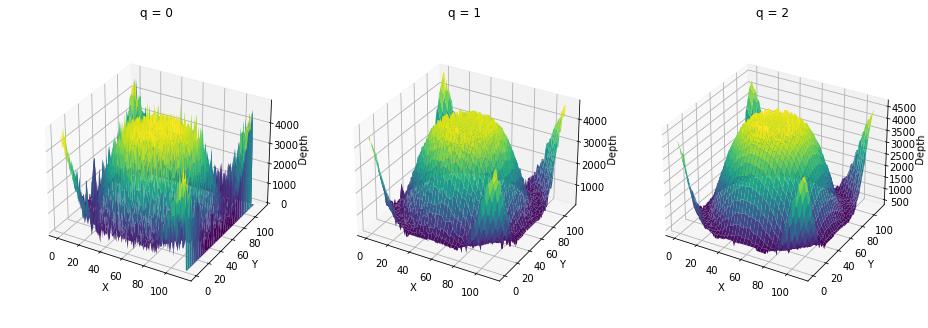

In [5]:
## Plot the 3-D shape.
fig, axs = plt.subplots(1, 3, figsize=(13, 5), subplot_kw={"projection": "3d"})

for q in qs:
    x = np.linspace(0, depths[q].shape[0]-1, depths[q].shape[0])
    y = np.linspace(0, depths[q].shape[1]-1, depths[q].shape[1])
    x, y = np.meshgrid(x, y)
    axs[q].plot_surface(x, y, depths[q], cmap='viridis', edgecolor='none')
    axs[q].set_title("q = " + str(q))
    axs[q].set_xlabel("X")
    axs[q].set_ylabel("Y")
    axs[q].set_zlabel("Depth")
    axs[q].set_box_aspect(None, zoom=0.85)
fig.tight_layout()
fig.savefig('data/output/shape.jpg')

**Observation**: The inferred depth is less noisy as $q$ increases.